In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from sklearn.decomposition import NMF

# Load the configuration file

In [2]:
with open("workspace/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

lame = config['lame']
path = f"{config['path_to_data']}/{lame}"

# Load the data

In [3]:
# Load the selected peaks in the region with the given frequency
peaks = pd.read_csv(f"{path}/results/mse_spectra_region.csv")

# Load the selected region pixels features
pixels = pd.read_csv(f"{path}/results/mse_pixels_region.csv")

# Plot the pixels densities extracted from the IHC images

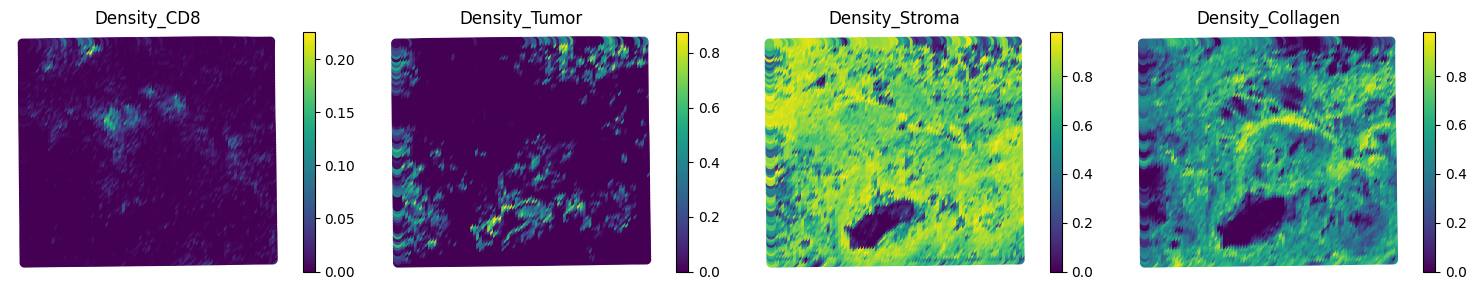

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density], cmap='viridis')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

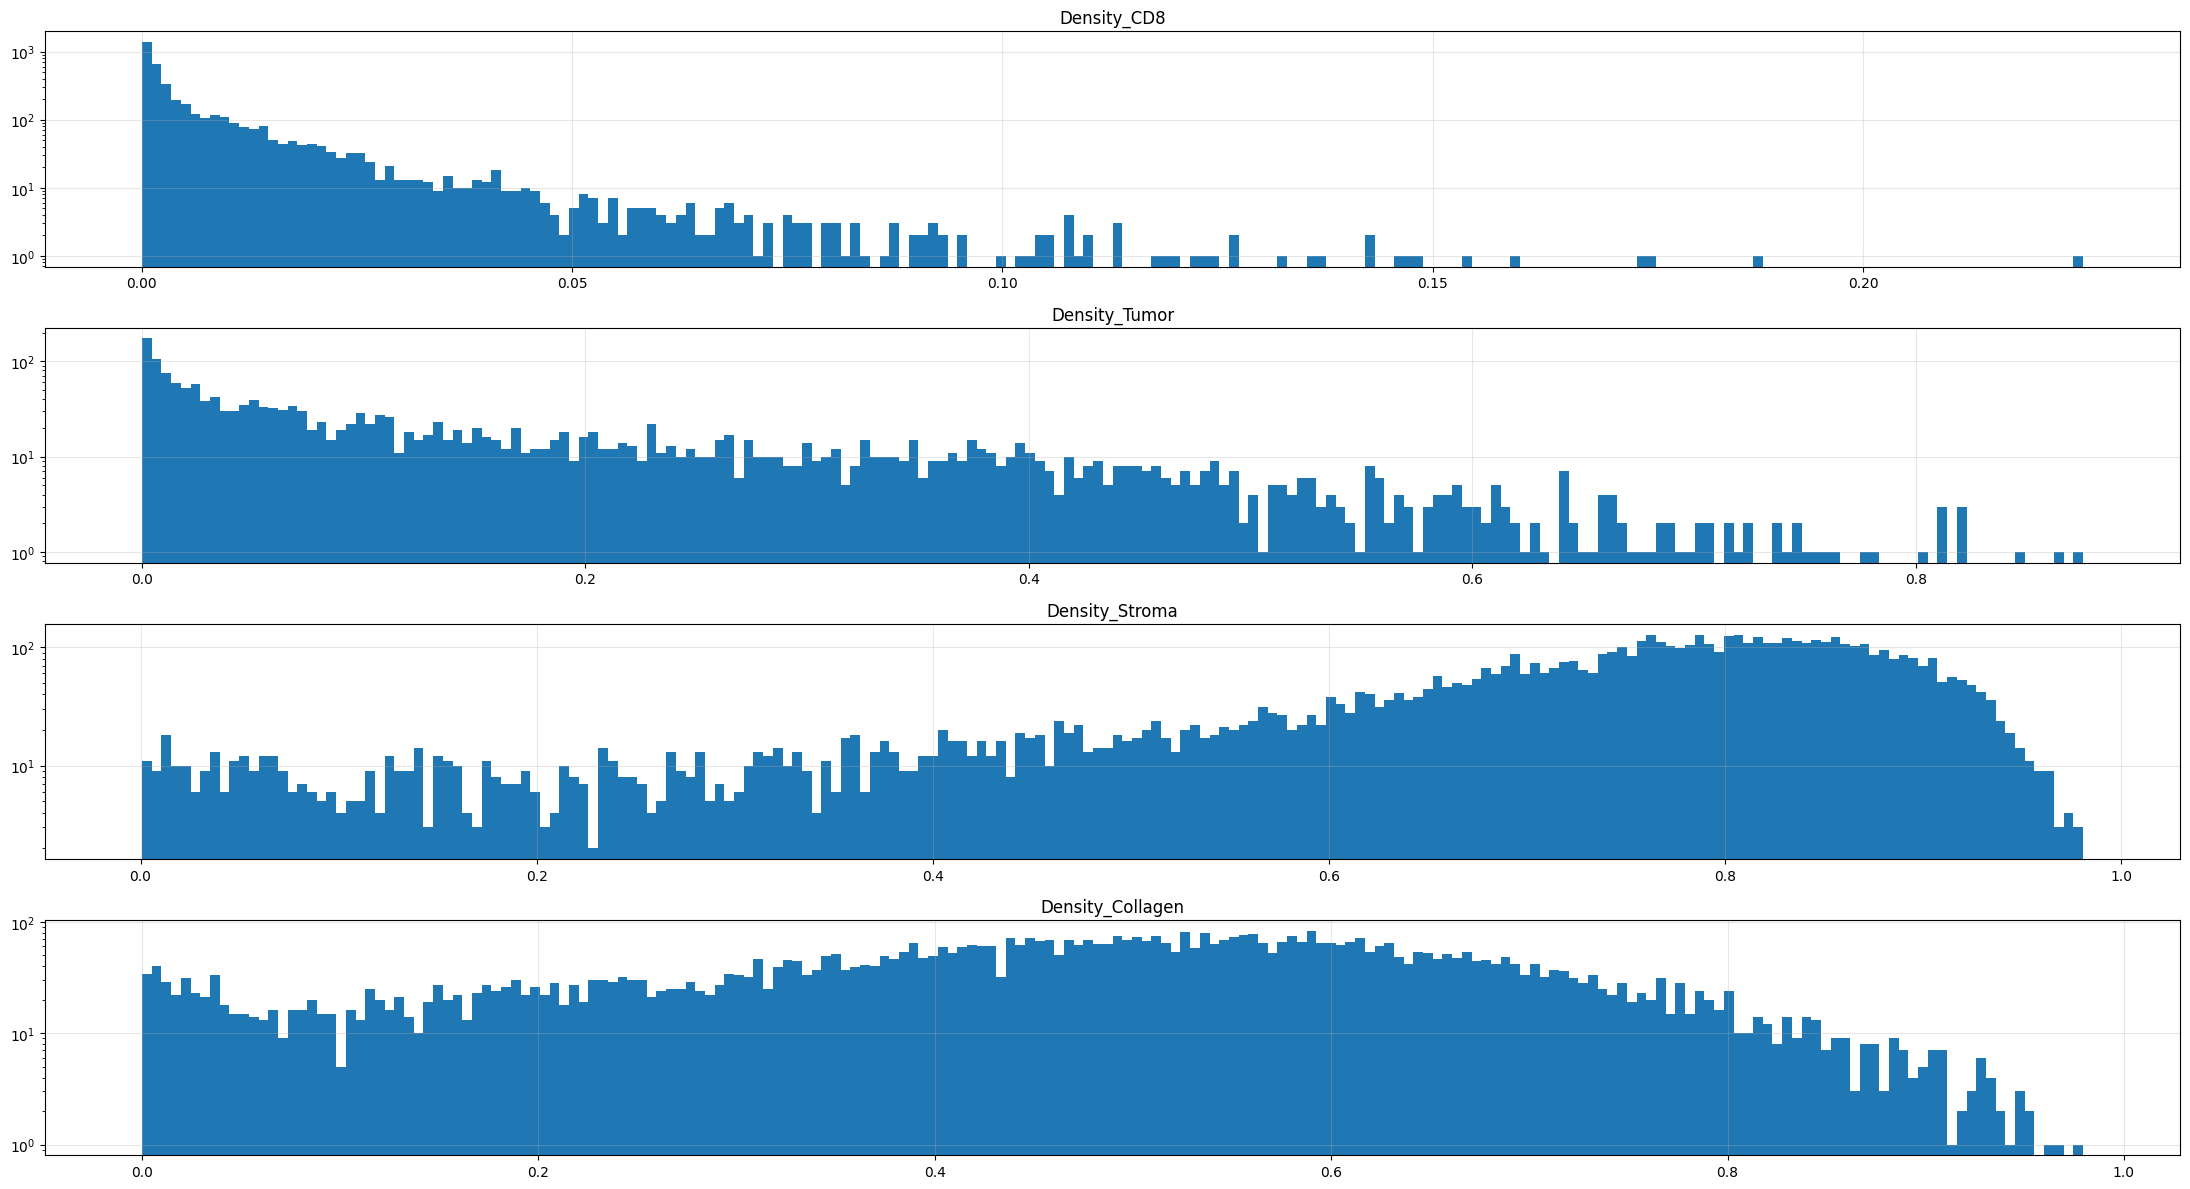

In [5]:
# Make a histogram of the pixel densities data
fig, axs = plt.subplots(4, 1, figsize=(22, 12), tight_layout=True)

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.hist(pixels[density][pixels[density] != 0], bins=200)
    ax.set_title(density)
    ax.set_yscale('log')
    ax.grid(alpha=0.3)

plt.show()

# Define a threshold for the pixel densities, then plot the density thresholded masks

In [6]:
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

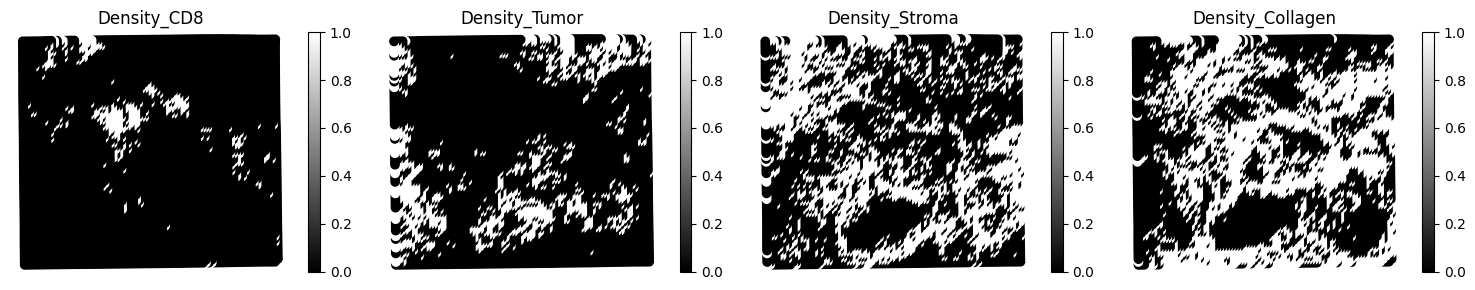

In [7]:
# plot the pixels densities with threshold
fig, axs = plt.subplots(1, 4, figsize=(15, 3), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, density in zip(axs.flatten(), [col for col in pixels.columns if 'Density' in col][:-2]):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=pixels[density] > threshold[density], cmap='gray')
    ax.set_title(density)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

plt.show()

# Perform Non-Negative Matrix Factorization (NMF) on the peaks

In [8]:
# Define the data set
V = peaks.values

# Define the NMF model
model = NMF(n_components=32,
            init='nndsvd',
            solver='cd',
            max_iter=10**6,
            random_state=42)

# Fit the model to the data
W = model.fit_transform(V)

# Calculate the reconstruction error

In [9]:
# Get the components of the model
H = model.components_

#  Reconstruct the data
V_approx = np.dot(W, H)

# Calculate the reconstruction error using the Frobenius norm
reconstruction_error = np.linalg.norm(V - V_approx, ord='fro')

print(f'Reconstruction Error (Frobenius norm) = {reconstruction_error:.2f}')

Reconstruction Error (Frobenius norm) = 907.74


# Plot the components of the model as Heatmaps

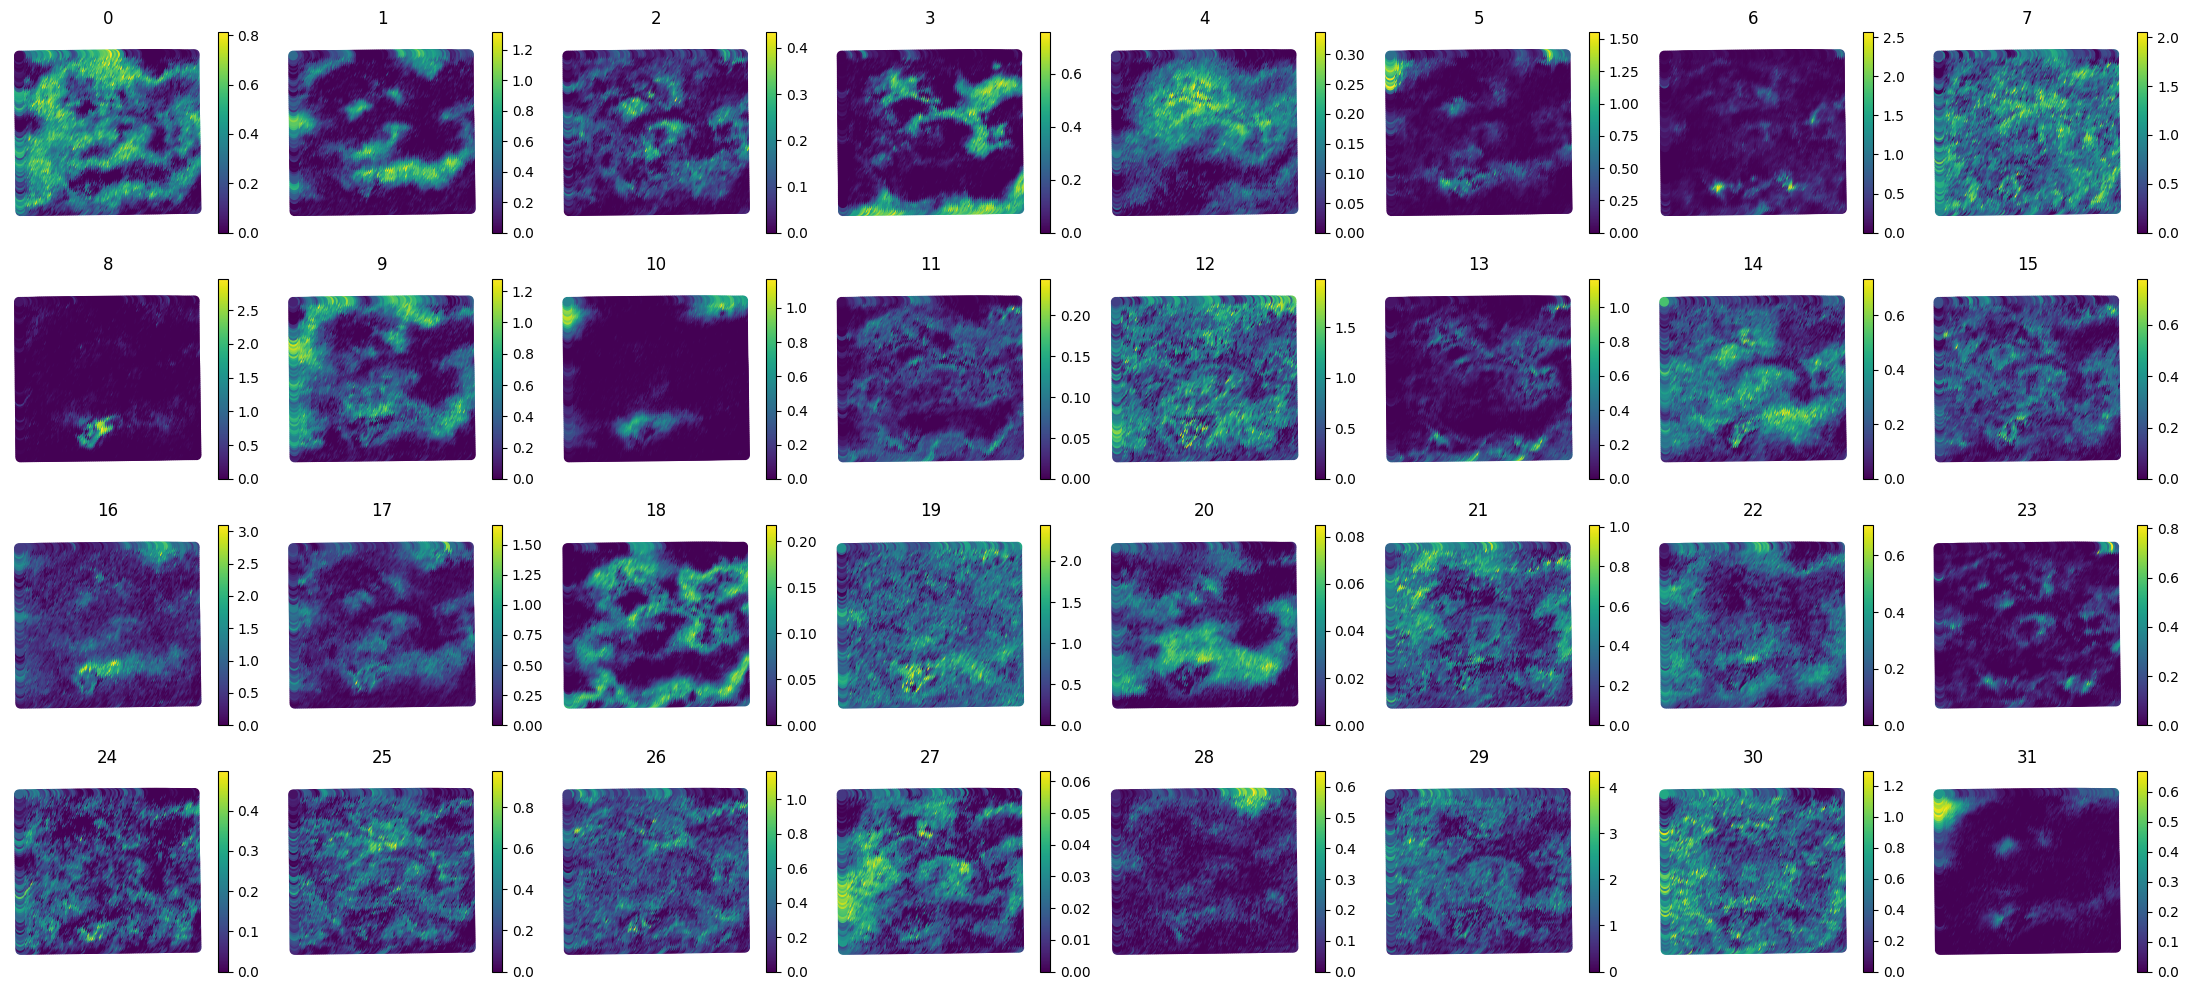

In [10]:
# Put the factors in a DataFrame
factors = pd.DataFrame(W, columns=[i for i in range(W.shape[1])])

# plot a Heatmap of the factors
fig, axs = plt.subplots(4, 8, figsize=(22, 10), tight_layout=True)
for ax in axs.flatten():
    ax.axis('off')

for ax, factor in zip(axs.flatten(), factors.columns):
    ax.scatter(x=pixels['x_warped'], y=pixels['y_warped'], c=factors[factor], cmap='viridis')
    ax.set_title(factor)
    ax.invert_yaxis()
    ax.axis('equal')
    fig.colorbar(ax.collections[0], ax=ax)

## Compute the Pearson and Spearman correlation matrices of the factors with the pixel densities, also compute the log2 fold change of the factors between the pixels with densities above and below the threshold.

In [11]:
# Spearman correlation
correlations_spearman = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    correlations_spearman[density] = [factors[factor].corr(pixels[density], method='spearman')
                                      for factor in factors.columns]
    
# Pearson correlation
correlations_pearson = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    correlations_pearson[density] = [factors[factor].corr(pixels[density], method='pearson')
                                      for factor in factors.columns]
    
# Compute the log2fold change of the factors between the thresholded images
log2fold_change = {}
for density in [col for col in pixels.columns if 'Density' in col][:-2]:
    log2fold_change[density] = [np.log2(factors[factor][pixels[density] > threshold[density]].mean() /
                                  factors[factor][pixels[density] <= threshold[density]].mean())
                               for factor in factors.columns]
    
# Create dataframes
df_spearman = pd.DataFrame(correlations_spearman, index=factors.columns)
df_pearson = pd.DataFrame(correlations_pearson, index=factors.columns)
df_log2fold_change = pd.DataFrame(log2fold_change, index=factors.columns)

# Plot heatmap of the correlations and log2fold change

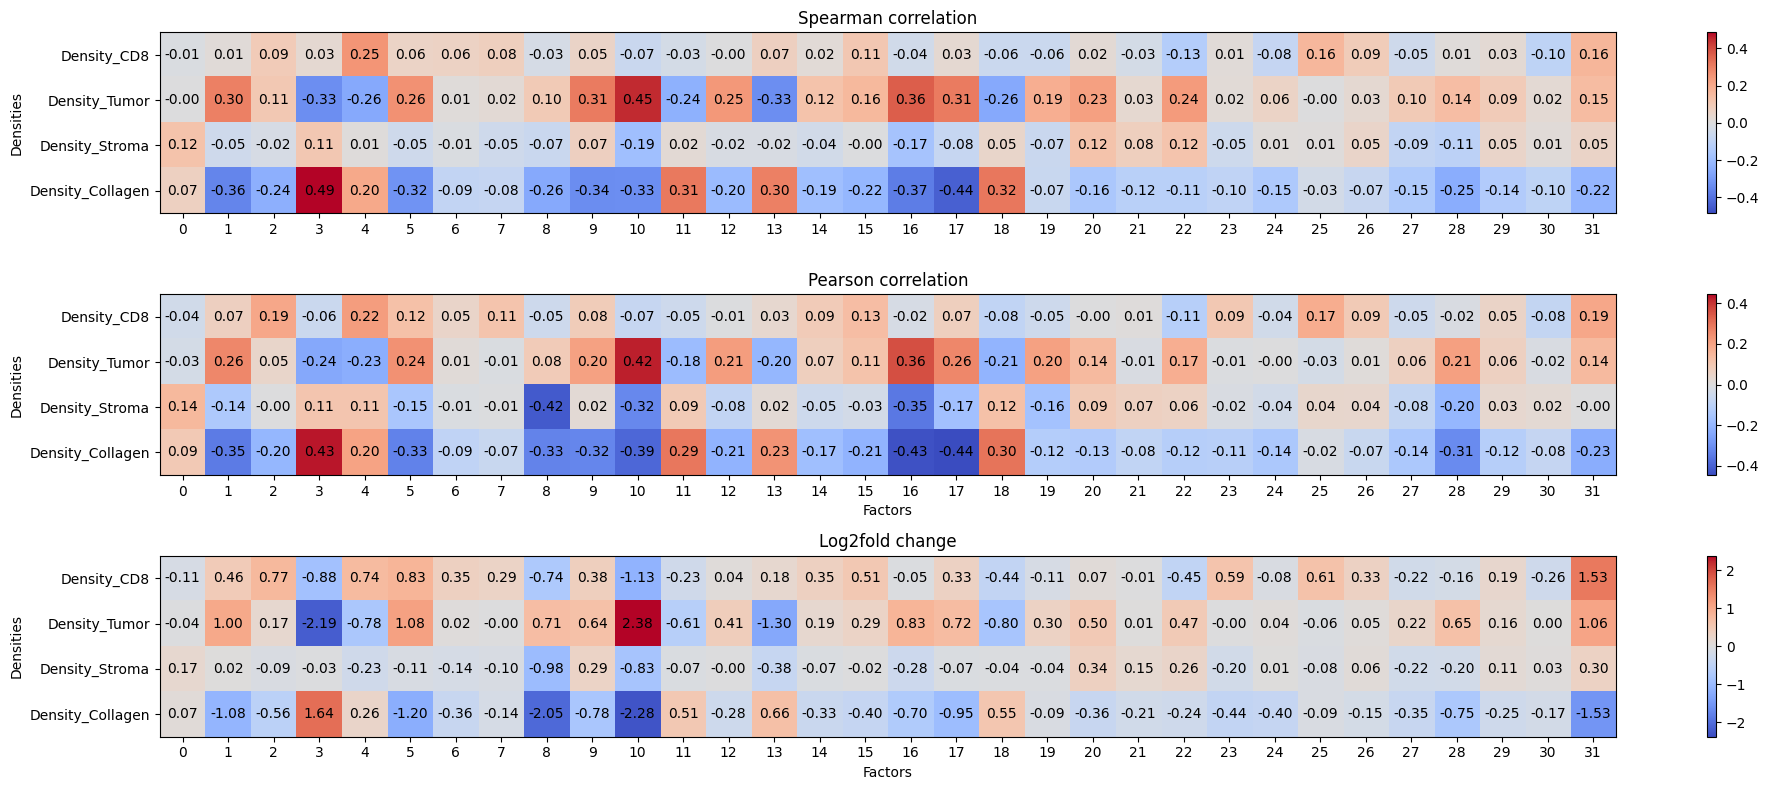

In [12]:
# Compute the absolute maximum values for the colorbar
df_spearman_abs_max = df_spearman.abs().max().max()
df_pearson_abs_max = df_pearson.abs().max().max()
log2fold_abs_max = np.abs(df_log2fold_change).max().max()

# Plot the correlations
fig, axs = plt.subplots(3, 1, figsize=(20, 8), tight_layout=True)

axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_spearman.shape[0]):
    for j in range(df_spearman.shape[1]):
        axs[0].text(i, j, f"{df_spearman.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[0].set_title('Spearman correlation')
axs[0].set_ylabel('Densities')
axs[0].set_xticks(range(df_spearman.shape[0]))
axs[0].set_yticks(range(df_spearman.shape[1]))
axs[0].set_yticklabels(df_spearman.columns)
cbar = fig.colorbar(axs[0].imshow(df_spearman.T, cmap='coolwarm', aspect='auto', vmin=-df_spearman_abs_max, vmax=df_spearman_abs_max))

axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_pearson.shape[0]):
    for j in range(df_pearson.shape[1]):
        axs[1].text(i, j, f"{df_pearson.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[1].set_title('Pearson correlation')
axs[1].set_ylabel('Densities')
axs[1].set_xlabel('Factors')
axs[1].set_xticks(range(df_pearson.shape[0]))
axs[1].set_yticks(range(df_pearson.shape[1]))
axs[1].set_yticklabels(df_pearson.columns)
cbar = fig.colorbar(axs[1].imshow(df_pearson.T, cmap='coolwarm', aspect='auto', vmin=-df_pearson_abs_max, vmax=df_pearson_abs_max))

axs[2].imshow(df_log2fold_change.T, cmap='coolwarm', aspect='auto')
# add annotations
for i in range(df_log2fold_change.shape[0]):
    for j in range(df_log2fold_change.shape[1]):
        axs[2].text(i, j, f"{df_log2fold_change.T.iloc[j, i]:.2f}", ha='center', va='center', color='black')
axs[2].set_title('Log2fold change')
axs[2].set_ylabel('Densities')
axs[2].set_xlabel('Factors')
axs[2].set_xticks(range(df_log2fold_change.shape[0]))
axs[2].set_yticks(range(df_log2fold_change.shape[1]))
axs[2].set_yticklabels(df_log2fold_change.columns)
cbar = fig.colorbar(axs[2].imshow(df_log2fold_change.T, cmap='coolwarm', aspect='auto', vmin=-log2fold_abs_max, vmax=log2fold_abs_max))

plt.show()